<a href="https://colab.research.google.com/github/shekharkhandelwal1983/DLforDataArchitects/blob/main/notebooks/chapter7/MaskRcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 11283, done.
remote: Counting objects: 100% (1485/1485), done.
remote: Compressing objects: 100% (738/738), done.
remote: Total 11283 (delta 860), reused 1258 (delta 710), pack-reused 9798
Receiving objects: 100% (11283/11283), 47.01 MiB | 30.80 MiB/s, done.
Resolving deltas: 100% (7898/7898), done.


In [2]:

from IPython import display
from PIL import Image
import numpy as np
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

In [4]:
# Loading images

--2023-07-04 11:35:51--  https://img.theculturetrip.com/768x/smart/wp-content/uploads/2019/11/r9j01k.jpg
Resolving img.theculturetrip.com (img.theculturetrip.com)... 13.249.85.69, 13.249.85.90, 13.249.85.98, ...
Connecting to img.theculturetrip.com (img.theculturetrip.com)|13.249.85.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89673 (88K) [image/jpeg]
Saving to: ‘test1.jpg’

test1.jpg           100%[===================>]  87.57K  --.-KB/s    in 0.02s   

2023-07-04 11:35:51 (5.42 MB/s) - ‘test1.jpg’ saved [89673/89673]



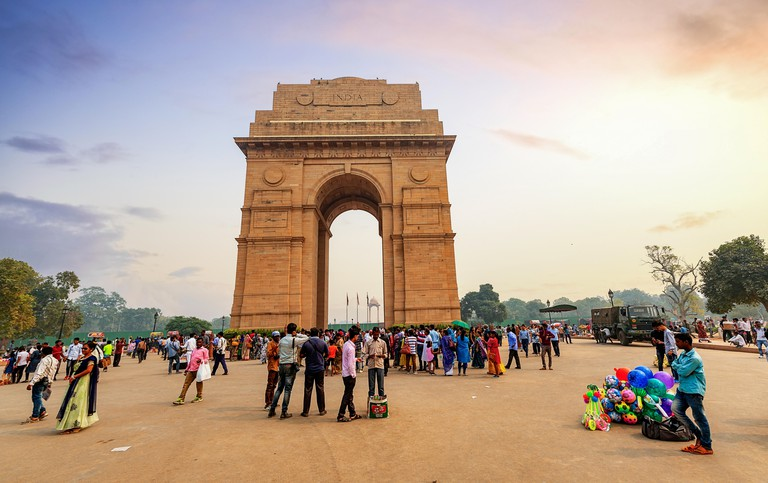

In [5]:
# Import the required libraries
import numpy as np
from PIL import Image
from IPython import display

# Download an image from a specific URL and save it as "test1.jpg"
!wget https://img.theculturetrip.com/768x/smart/wp-content/uploads/2019/11/r9j01k.jpg -O test1.jpg

# Set the path of the downloaded image
image_path = 'test1.jpg'

# Open the image file in binary mode
with open(image_path, 'rb') as file:
    # Convert the image data into a numpy array
    np_image_string = np.array([file.read()])

# Open the image using the PIL library
image = Image.open(image_path)

# Get the width and height of the image
width, height = image.size

# Convert the image data into a numpy array with the specified dimensions and data type
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

# Display the image with a width of 1024 pixels
display.display(display.Image(image_path, width=1024))

In [6]:
session = tf.Session(graph=tf.Graph())

In [7]:
# Loading pretarined model

saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
Use `tf.saved_model.load` instead.


In [8]:
# Instance Segmentation
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

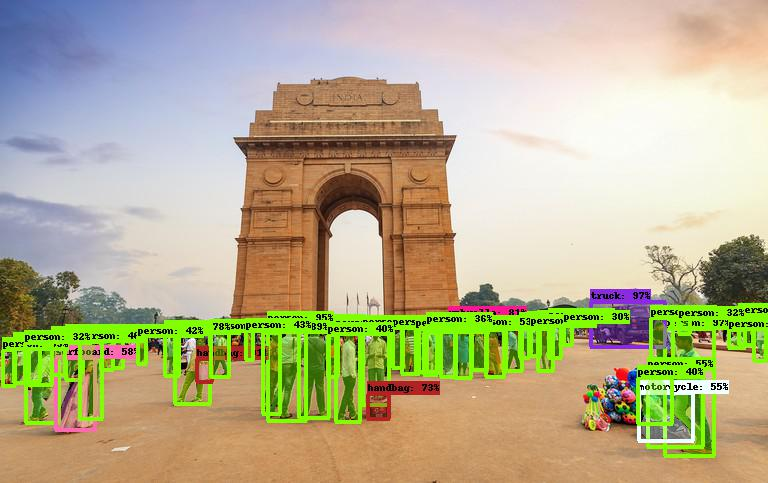

In [9]:
# Results
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.1    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))